In [1]:
import os
import torch
import random
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
from models import build_model
from PIL import Image

#### Building the LaVIT Model and Load the checkpoint

In [2]:
# The local directory to save LaVIT checkpoint
model_path='/home/jinyang06/models/LaVIT_checkpoint'
model_dtype='bf16'
device_id = 0
torch.cuda.set_device(device_id)
device = torch.device('cuda')

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For Multi-Modal Understanding
model = build_model(model_path=model_path, model_dtype=model_dtype,
             device_id=device_id, use_xformers=False, understanding=False)
model = model.to(device)    
print("Building Model Finsished")
torch_dtype = torch.bfloat16 if model_dtype=="bf16" else torch.float16

# Show multiple images together
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def show_and_save(images, rows=2, cols=2):
    grid = image_grid(images, rows=rows, cols=cols)
    display(grid.resize((512, 512)))
    for index, image in enumerate(images):
        image.save(f'output/image_{index}.jpg')

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading LaVIT Model Weight from /home/jinyang06/models/LaVIT_checkpoint, model precision: bf16


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Load eva vitG weight from /home/jinyang06/models/LaVIT_checkpoint/visual_tokenizer/eva_vitg_psz14.bin
Load visual tokenizer encoder weight from /home/jinyang06/models/LaVIT_checkpoint/visual_tokenizer/tokenizer_encoder.bin
Load visual tokenizer decoder weight from /home/jinyang06/models/LaVIT_checkpoint/visual_tokenizer/tokenizer_decoder.bin


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Building Model Finsished


#### Text-to-Image Synthesis

A small cactus wearing a straw hat and neon sunglasses in the Sahara desert.


100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


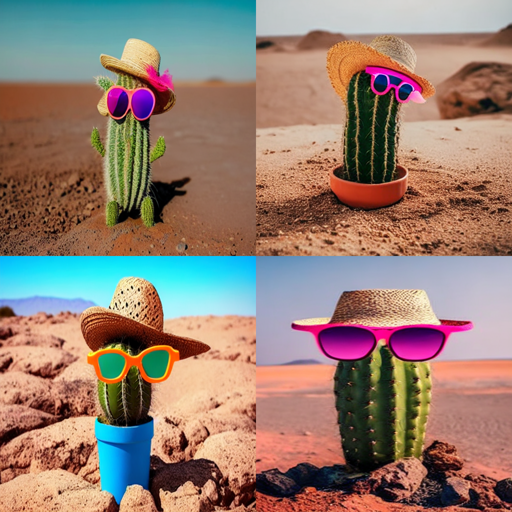

In [3]:
# Text-to-Image Generation
num_images = 4 # The generated image number
rows = 2; cols = 2
prompt = "A small cactus wearing a straw hat and neon sunglasses in the Sahara desert."
# prompt = 'A section of the Great Wall in the mountains. detailed charcoal sketch.'
# prompt = 'a super math wizard cat, richly textured oil painting'
# prompt = "A squirrel gives an apple to a bird"
# prompt = "A photo of an astronaut riding a horse in the forest. There is a river in front of them with water lilies."
# prompt = 'A photograph of a bird wearing headphones and speaking into a high-end microphone in a recording studio.'
# prompt = "A blue jay standing on a large basket of rainbow macarons"
# prompt = "A photo of a light bulb in outer space traveling the galaxy with a sailing boat inside the light bulb"
# prompt = "A large cabin on top of a sunny mountain"
# prompt = "A richly textured oil painting of a young badger delicately sniffing a yellow rose next to a tree trunk. A small waterfall can be seen in the background."

print(prompt)
with torch.cuda.amp.autocast(enabled=True, dtype=torch_dtype):
    images = model.generate_image(prompt, num_return_images=num_images, 
        guidance_scale_for_llm=3.0, num_inference_steps=50, top_k=200)
show_and_save(images, rows, cols)


#### Image Synthesis with Multi-modal Prompts

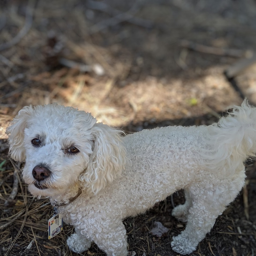

It is running in the snow


100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


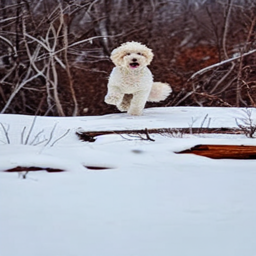

In [4]:
# Image + Text => Image
image_prompt = 'demo/dog.jpg'
text_prompt = 'It is swimming in the river'
text_prompt = 'It is running in the snow'
input_prompts = [(image_prompt, 'image'), (text_prompt, 'text')]
display(Image.open(image_prompt).resize((256, 256)))
print(text_prompt)

with torch.cuda.amp.autocast(enabled=True, dtype=torch_dtype):
    images = model.multimodal_synthesis(input_prompts, guidance_scale_for_llm=5.0, 
        num_return_images=4, num_inference_steps=50)
display(images[0].resize((256, 256)))


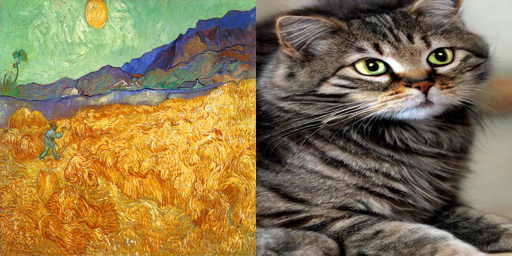

100%|██████████| 50/50 [00:03<00:00, 15.76it/s]


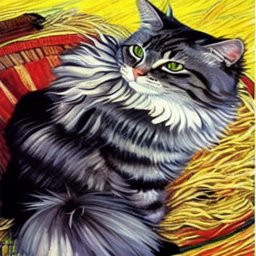

In [5]:
# Image + Image => Image
image1 = 'demo/image_input1.jpg'
image2 = 'demo/image_input2.jpg'
input_prompts = [(image1, 'image'), (image2, 'image')]
display(image_grid([Image.open(image1).resize((256, 256)), Image.open(image2).resize((256, 256))], 1, 2))
with torch.cuda.amp.autocast(enabled=True, dtype=torch_dtype):
    images = model.multimodal_synthesis(input_prompts, guidance_scale_for_llm=5.0, 
        num_return_images=1, num_inference_steps=50)
display(images[0].resize((256, 256)))
